In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
order_data = pd.read_csv('orders.csv')
customers_data = pd.read_csv('customers.csv')

In [3]:
data = pd.merge(order_data, customers_data, how='left', left_on='customer_id',  right_on='id')

In [4]:
data.drop_duplicates(inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5009 entries, 0 to 5008
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_x         5009 non-null   int64  
 1   order_date   5009 non-null   object 
 2   ship_mode    5009 non-null   object 
 3   customer_id  5009 non-null   object 
 4   sales        5009 non-null   float64
 5   id_y         5009 non-null   object 
 6   name         5009 non-null   object 
 7   segment      5009 non-null   object 
 8   state        5009 non-null   object 
 9   city         5009 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 430.5+ KB


In [6]:
data['order_month'] = data['order_date'].astype('datetime64').dt.strftime('%Y-%m')
data['order_year'] = data['order_date'].astype('datetime64').dt.strftime('%Y')

In [7]:
data

,id_x,order_date,ship_mode,customer_id,sales,id_y,name,segment,state,city,order_month,order_year
0,100006,2014-09-07,Standard,DK-13375,377.970,DK-13375,Dennis Kane,Consumer,Ohio,Marion,2014-09,2014
1,100090,2014-07-08,Standard,EB-13705,699.192,EB-13705,Ed Braxton,Corporate,Ohio,Akron,2014-07,2014
2,100293,2014-03-14,Standard,NF-18475,91.056,NF-18475,Neil Franzosisch,Home Office,Illinois,Rockford,2014-03,2014
3,100328,2014-01-28,Standard,JC-15340,3.928,JC-15340,Jasper Cacioppo,Consumer,California,Los Angeles,2014-01,2014
4,100363,2014-04-08,Standard,JM-15655,21.376,JM-15655,Jim Mitchum,Corporate,New Jersey,Bridgeton,2014-04,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368,JO-15145,Jack O'Briant,Corporate,Pennsylvania,Philadelphia,2017-11,2017
5005,169320,2017-07-23,Second,LH-16900,171.430,LH-16900,Lena Hernandez,Consumer,Delaware,Dover,2017-07,2017
5006,169488,2017-09-07,First,AA-10375,56.860,AA-10375,Allen Armold,Consumer,Arizona,Mesa,2017-09,2017
5007,169502,2017-08-28,Standard,MG-17650,113.410,MG-17650,Matthew Grinstein,Home Office,Pennsylvania,Philadelphia,2017-08,2017


## Исследуем churn-rate (метрику оттока клиентов).

Но проблема в том, что мы не знаем, какого клиента считать "неактивным" в случае интернет-магазина. Есть идея строить распределение частот покупки и уже относительного этого искать момент, когда уже можно сказать, что пользователь не вернётся к нам.

In [8]:
def churn_rate(data, start, prev, period='month'):
    unique_prev = data[data[f'order_{period}'] == prev]['customer_id'].unique()
    c2 = np.intersect1d(unique_prev, \
               data[(data[f'order_{period}'] == start)]['customer_id'].unique())
    c1 = unique_prev
    return (len(c1) - len(c2)) / len(c1) * 100

In [9]:
month_2016 = np.sort(data[data['order_year'] == '2016']['order_month'].unique())
date_prev = np.sort((pd.DataFrame(month_2016).astype('datetime64') - pd.DateOffset(months=1))[0].astype('datetime64').dt.strftime('%Y-%m').values)
churn_rate_2016 = []
for date, prev in zip(month_2016, date_prev):
    churn_rate_2016.append(churn_rate(data, date, prev))

In [10]:
month_2017 = np.sort(data[data['order_year'] == '2017']['order_month'].unique())
date_prev = np.sort((pd.DataFrame(month_2017).astype('datetime64') - pd.DateOffset(months=1))[0].astype('datetime64').dt.strftime('%Y-%m').values)
churn_rate_2017 = []
for date, prev in zip(month_2017, date_prev):
    churn_rate_2017.append(churn_rate(data, date, prev))

## churn-rate в разрезе месяца для 2016 и 2017 годов

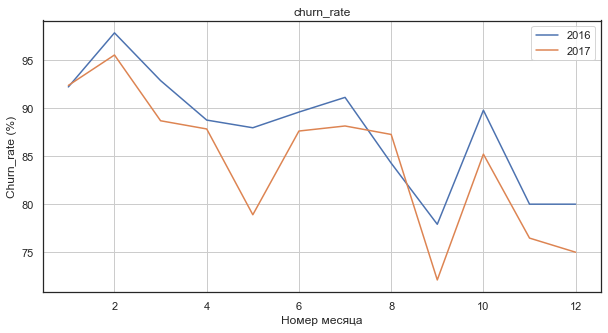

In [11]:
sns.set(style='white')
plt.figure(figsize=(10, 5))
plt.title('churn_rate')
plt.plot([i for i in range(1, 13)], churn_rate_2016, label='2016')
plt.plot([i for i in range(1, 13)], churn_rate_2017, label='2017')
plt.xlabel('Номер месяца')
plt.ylabel('Churn_rate (%)')
plt.legend()
plt.grid()
plt.show()

## Churn-rate в разрезе года

In [19]:
churn_rate_year = [] 
for date, prev in zip(['2016', '2017'], ['2015', '2016']):
    churn_rate_year.append(churn_rate(data, date, prev, 'year'))
pd.DataFrame(index=['2016', '2017'], data=churn_rate_year, columns=['churn_rate_year'])

,churn_rate_year
2016,21.116928
2017,12.539185


## Проведём когортный анализ

In [20]:
cohorts = data.groupby('customer_id', as_index=False)['order_month'].min()
cohorts.rename(columns = {'order_month':'cohort'}, inplace=True)
cohorts_year = data.groupby('customer_id', as_index=False)['order_year'].min()
cohorts_year.rename(columns = {'order_year':'cohort_year'}, inplace=True)

In [21]:
df_merged = pd.merge(data, cohorts, how='left', on='customer_id')
df_merged = pd.merge(df_merged, cohorts_year, how='left', on='customer_id')
df_merged.head()

,id_x,order_date,ship_mode,customer_id,sales,id_y,name,segment,state,city,order_month,order_year,cohort,cohort_year
0,100006,2014-09-07,Standard,DK-13375,377.970,DK-13375,Dennis Kane,Consumer,Ohio,Marion,2014-09,2014,2014-09,2014
1,100090,2014-07-08,Standard,EB-13705,699.192,EB-13705,Ed Braxton,Corporate,Ohio,Akron,2014-07,2014,2014-07,2014
2,100293,2014-03-14,Standard,NF-18475,91.056,NF-18475,Neil Franzosisch,Home Office,Illinois,Rockford,2014-03,2014,2014-03,2014
3,100328,2014-01-28,Standard,JC-15340,3.928,JC-15340,Jasper Cacioppo,Consumer,California,Los Angeles,2014-01,2014,2014-01,2014
4,100363,2014-04-08,Standard,JM-15655,21.376,JM-15655,Jim Mitchum,Corporate,New Jersey,Bridgeton,2014-04,2014,2014-04,2014


In [22]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [23]:
cohorts_group = df_merged.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'TotalUsers'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True)
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention = user_retention.T.sort_values(by='cohort', ascending=False)

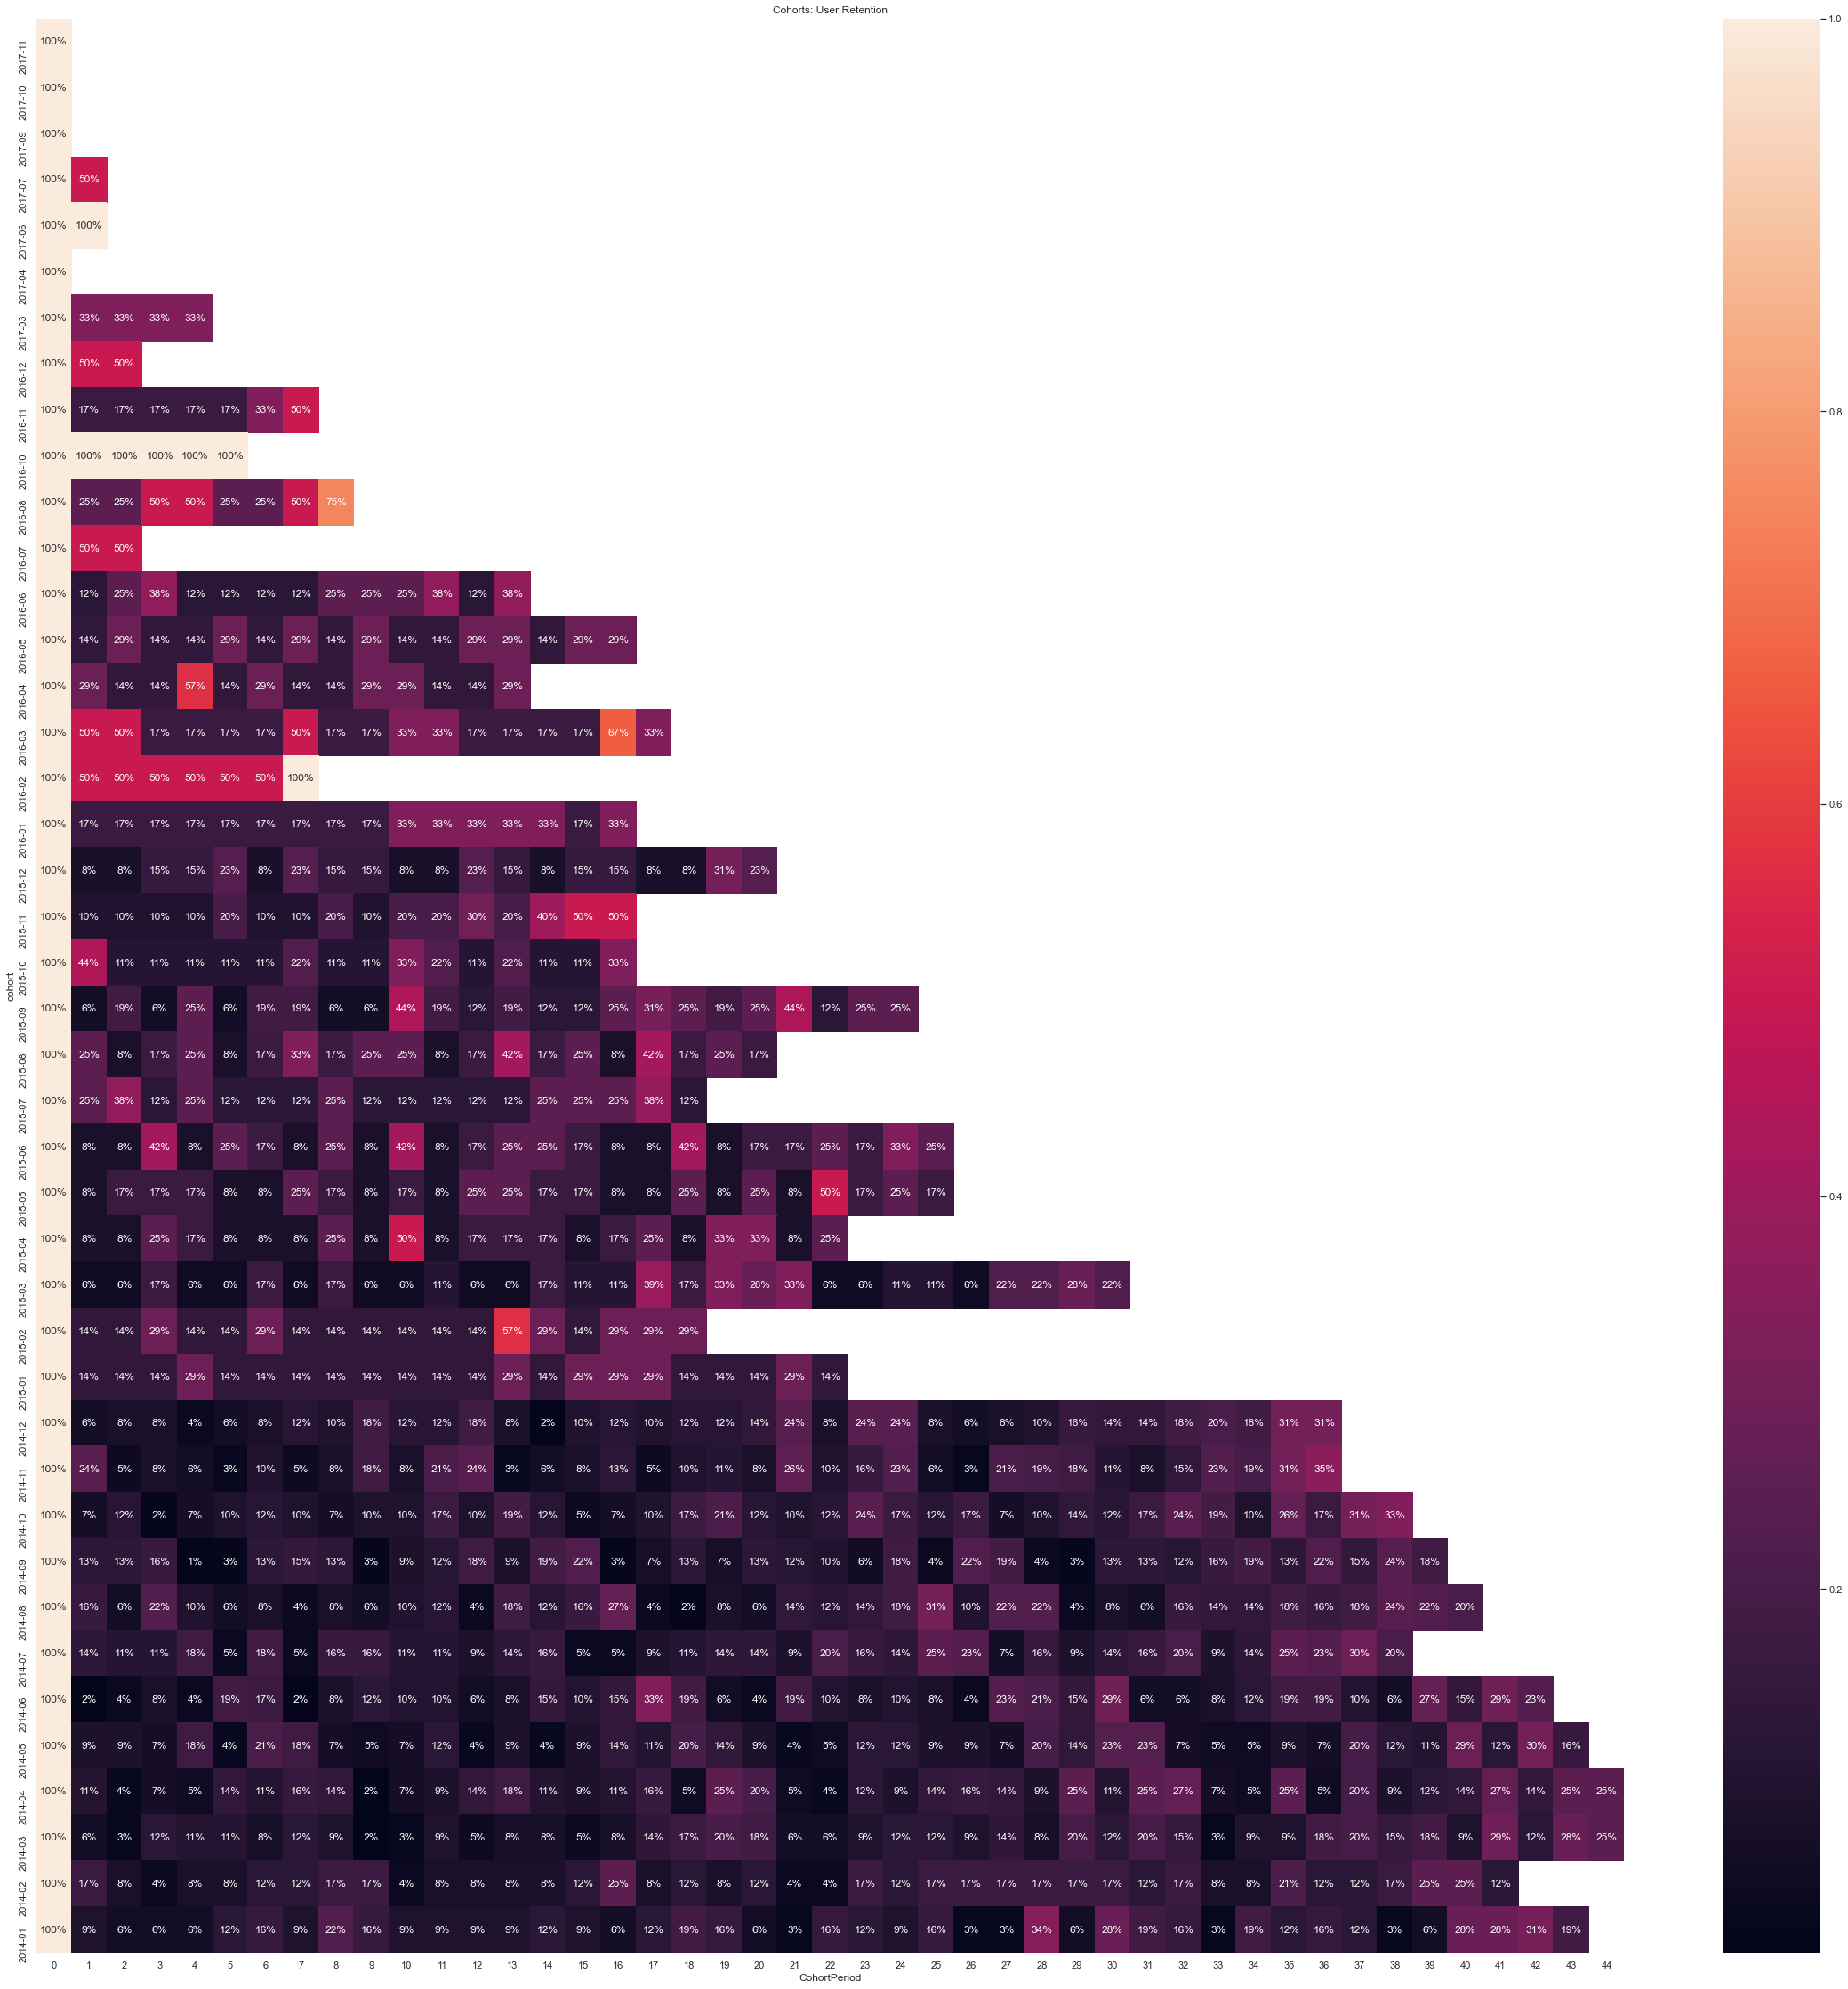

In [24]:
sns.set(style='white')
plt.figure(figsize=(40, 40))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention, mask=user_retention.isnull(), annot=True, fmt='.0%');

In [41]:
data_merge = pd.merge(df_merged.groupby(['order_month']).agg({'customer_id': pd.Series.nunique}).reset_index(), \
df_merged.groupby(['cohort']).agg({'customer_id': pd.Series.nunique}).reset_index(), left_on='order_month', right_on='cohort', 
                      how='left').fillna(0).rename(
    columns={'customer_id_x' : 'count_uniq_month', 'customer_id_y' : 'count_uniq_user'}
)[['order_month', 'count_uniq_month', 'count_uniq_user']]

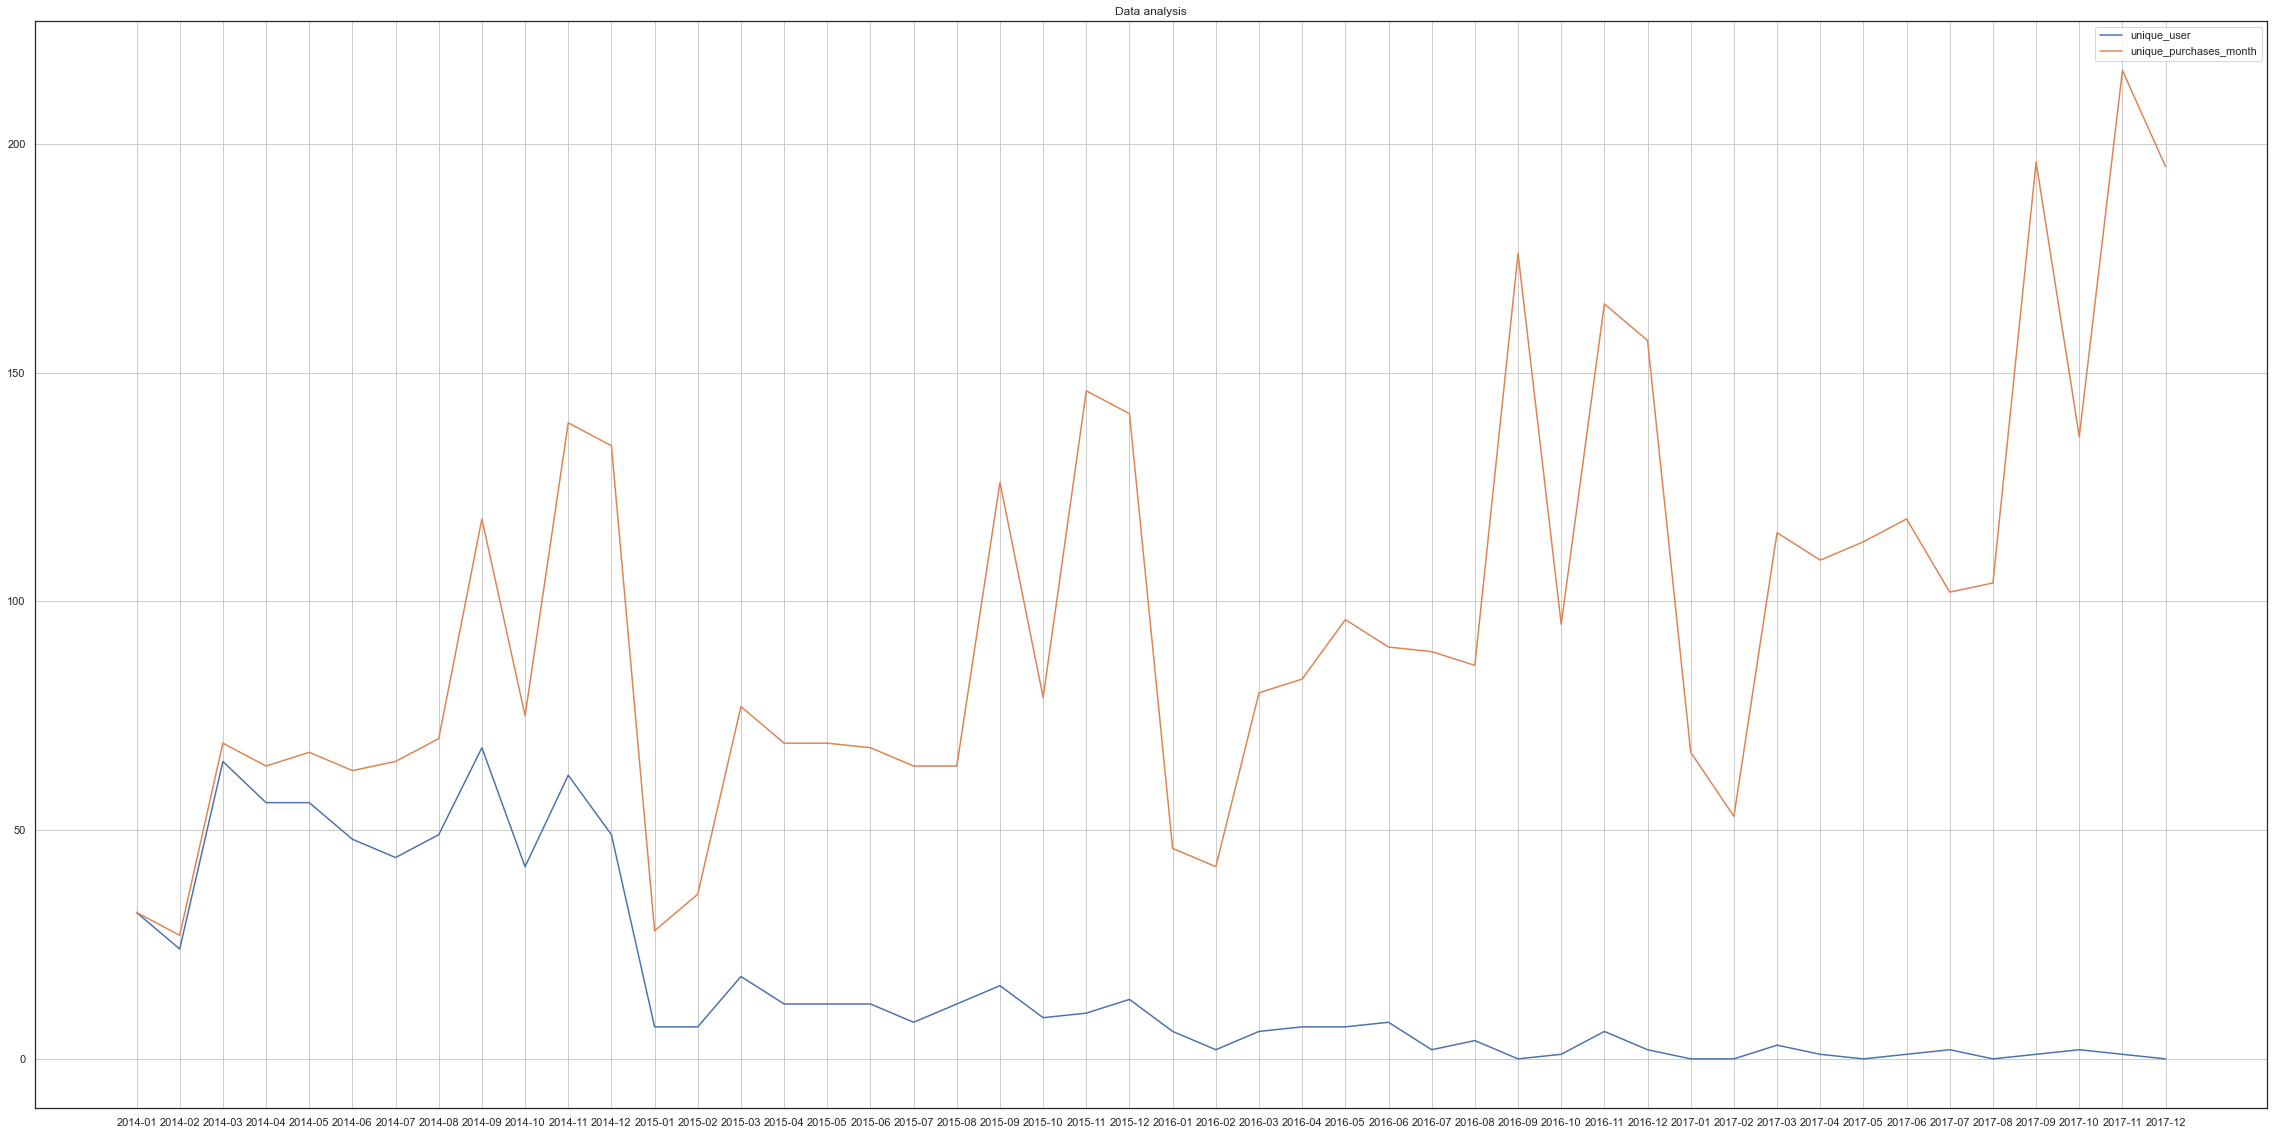

In [69]:
plt.figure(figsize=(40, 20))
plt.title('Data analysis')
plt.plot(data_merge['order_month'], data_merge['count_uniq_user'], label='unique_user')
plt.plot(data_merge['order_month'], data_merge['count_uniq_month'], label='unique_purchases_month')
#plt.plot(data_merge['order_month'], data_merge['count_uniq_user'].cumsum(), label='total_users')
plt.grid()
plt.legend()
plt.show()

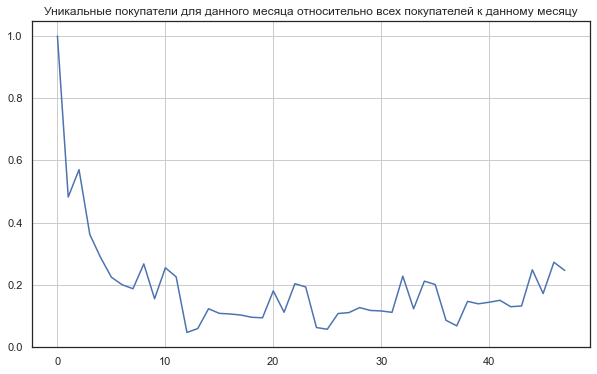

In [68]:
plt.figure(figsize=(10, 6))
plt.title('Уникальные покупатели для данного месяца относительно всех покупателей к данному месяцу')
plt.plot(data_merge['count_uniq_month'] / data_merge['count_uniq_user'].cumsum())
plt.grid()
plt.show()

Можно заметить, что к 2017ому году количество новых покупателей падало со временем и в 2017 имело наименьшие значение. При этом количество покупок в 2017 выросло по сравнению с 2016 не засчёт каких-то пользователей-поклонников, которые стали больше покупать (об этом говорит последний график), а засчёт "старичков", которые к нам возвращаются больше, чем в 2016. Churn-rate метрика говорит нам о том, что отток в 2017 году не возрос по сравнению с 2016ым, поэтому гипотезу директора можно считать неправильной, иначе бы не росли продажи за счёт "старичков", потому что "старичков" становилось бы меньше, чем в 2016 и других годах из-за падения уникальных покупателей.